In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import matplotlib.pyplot as plt

import numpy as np
import pickle
import yaml
from RetaredHarmonicDynamics import animate_particle
from matplotlib import animation
from scipy.stats import moment
from scipy.special import factorial, lambertw, erf
from pathlib import Path

tensor = torch.tensor

from my_functions import get_pos, get_mean_std, FokkerPlankCalculator, time_delayed_harmonic, damped_harmonic_oszillator
from my_functions import get_approx_freq,get_zero, get_pos_with_border, get_pos_mirror

pic_path = Path('Graphic_Results/')

save_run = False

# num_particle = 20000
# border = 0.7e-3
# max_t = 8
# dt = 4e-3

# k = 15
# tau = 0

with open('std_parameter_setting.yaml') as f:
    std_parameter_setting = yaml.load(f , Loader=yaml.SafeLoader)

num_particle = std_parameter_setting['num_particle']
max_t = std_parameter_setting['max_t']
dt = std_parameter_setting['dt']

tau = std_parameter_setting['tau']
k = std_parameter_setting['k']
border = std_parameter_setting['border']

D = float(std_parameter_setting['D'])

In [3]:
pos = get_pos_mirror(x_m = border, tau=tau, k=k,dt=dt)
last_min_tensor = torch.zeros_like(pos) # if pos = -1 last min left if pos = 1 last min right
last_min_tensor[pos <= -border] = -1
last_min_tensor[pos >= border] = 1

for i in range(len(last_min_tensor)):
    last_min_tensor[i][last_min_tensor[i] == 0] = last_min_tensor[i-1][last_min_tensor[i] == 0]

In [4]:
crossings = ((last_min_tensor[1:]*last_min_tensor[:-1]) < 0).sum(axis=0).float()

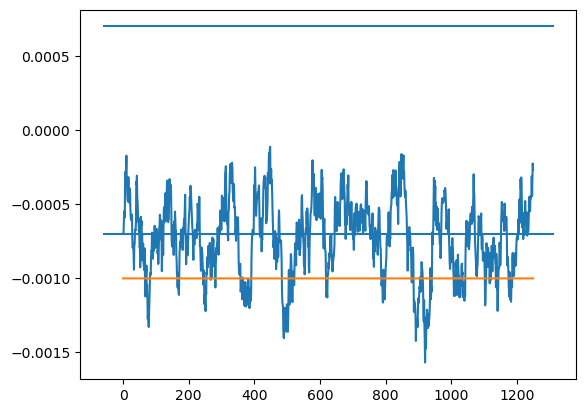

In [5]:
plt.plot(pos[:,4])
plt.plot(last_min_tensor[:,4]*0.001)
plt.hlines([-border,border],*plt.xlim())

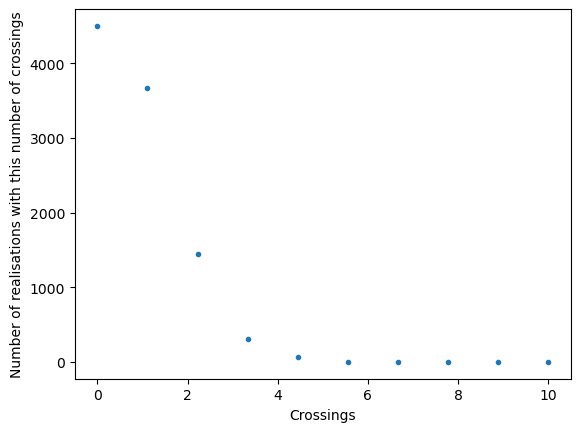

In [6]:
xlim = (0,10)
hist = crossings.histc(bins=xlim[1], min=xlim[0], max=xlim[1], )
plt.plot(np.linspace(*xlim,xlim[1]),hist,'.')
plt.xlabel('Crossings')
plt.ylabel('Number of realisations with this number of crossings')
crossings_min_bound = {tau:hist}
# %store crossings_min_bound
with open('nummeric_results/crossings_min_bound.pkl','wb') as f:
    pickle.dump(crossings_min_bound, f)

In [7]:
def plot_simulated_rate(
    k,
    tau,
    border,
    dt = 1e-3,
    num_particle = 20000,
    max_t = 2.5,
    F=lambda i:0,
    safe_name=None):
    pos = get_pos_mirror(x_m = border, num_particle=num_particle, max_t = max_t+tau,  dt = dt, tau=tau, k=k, F=F)[int(tau/dt):]
    last_min_tensor = torch.zeros_like(pos) # if pos = -1 last min left if pos = 1 last min right
    last_min_tensor[pos <= -border] = -1
    last_min_tensor[pos >= border] = 1

    for i in range(len(last_min_tensor)):
        last_min_tensor[i][last_min_tensor[i] == 0] = last_min_tensor[i-1][last_min_tensor[i] == 0]
    print('got', len(pos))
    time = np.linspace(0,max_t,len(pos))
    particles = (pos < 0).sum(1)

    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].plot(time,particles)
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Number of particles')

    p_diff_raw = particles.diff(dim=0)*1.
    crossings_raw = ((last_min_tensor[1:]*last_min_tensor[:-1]).sign() + last_min_tensor[:-1].sign() == -2).sum(axis=1)+0.
    p_diff = p_diff_raw.clone()
    crossings = crossings_raw.clone()
    
    mean_bin = 50
    p_diff = p_diff.squeeze()
    p_diff = torch.stack([p_diff.repeat(mean_bin,1).diag(i).mean() for i in range(len(p_diff))])
    p_diff = p_diff.unsqueeze(1)
    
    crossings = crossings.squeeze()
    crossings = torch.stack([crossings.repeat(mean_bin,1).diag(i).mean() for i in range(len(crossings))])
    crossings = crossings.unsqueeze(1)
    
    # for i in range(500):
    #     p_diff[1:-1] = (p_diff[2:]+p_diff[1:-1]+p_diff[:-2])/3
    #     p_diff[0] = (p_diff[0]+p_diff[1])/2
    #     p_diff[-1] = (p_diff[-1]+p_diff[-2])/2
    #     crossings[1:-1] = (crossings[2:]+crossings[1:-1]+crossings[:-2])/3
    #     crossings[0] = (crossings[0]+crossings[1])/2
    #     crossings[-1] = (crossings[-1]+crossings[-2])/2
    
    
    axs[1].plot(time[:-1],p_diff_raw, alpha=0.2, label='raw')
    axs[1].plot(time[:-1],p_diff, label='smoothed')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Change of number of particles')
    axs[1].legend()
    axs[2].plot(time[:-1],crossings_raw, alpha=0.2, label='raw')
    axs[2].plot(time[:-1],crossings, label='smoothed')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Crossing left to right of particles')
    axs[2].legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if safe_name:
        plt.savefig(pic_path/f'{safe_name}_particles.pdf')
    plt.show()
    
    rate_raw = -p_diff_raw/particles[1:]/dt
    rate = -p_diff/particles[1:]/dt
    crossing_rate = crossings/particles[1:]/dt
    crossing_rate_raw = crossings_raw/particles[1:]/dt
    
    # plt.plot(time[:-1],rate_raw, alpha=0.2)
    # plt.plot(time[:-1],rate)
    
    plt.plot(time[:-1],crossing_rate_raw, alpha=0.2)
    plt.plot(time[:-1],crossing_rate)
    
    average = 500
    print(rate_raw[-average:].mean(), 1/np.sqrt(average)*rate_raw[-average:].std())
    plt.xlabel("Time")
    plt.ylabel(r"Rate $\kappa$")
    if safe_name:
        plt.savefig(pic_path/f'{safe_name}_rate.pdf')
    plt.show()
    return pos,rate,crossing_rate, np.linspace(0,max_t,len(rate))

# No Force

got 1000


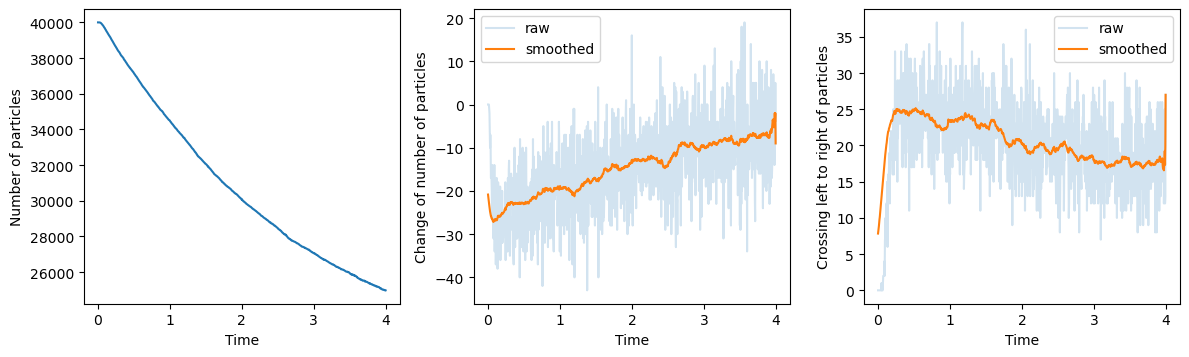

tensor(0.0927) tensor(0.0036)


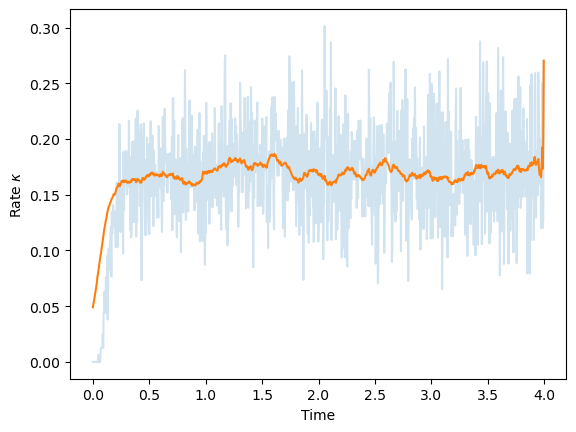

In [8]:
pos, rate_no_force,crossing_rate_no_force, time_no_force = plot_simulated_rate(
    k=k,
    tau=tau,
    border=border,
    num_particle=num_particle,
    max_t=max_t,
    dt=dt,
    safe_name='no_force')

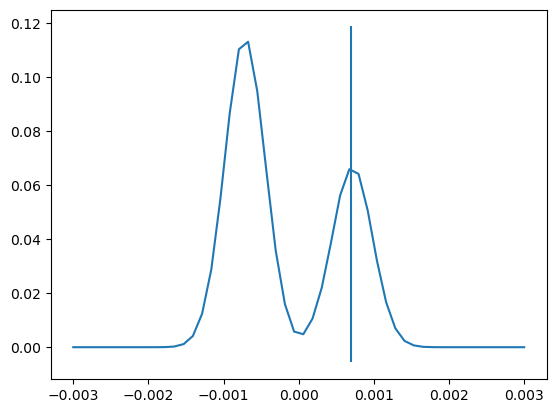

In [9]:
average = 50
xlim = (-3e-3,3e-3)
values = pos[-average:,:,0].flatten()
hist = values[~values.isnan()].float().histc(bins=50, min=xlim[0], max=xlim[1], )/num_particle/average

plt.plot(np.linspace(*xlim,50),hist)
plt.vlines([border],*plt.ylim())

In [10]:
values

tensor([ 0.0006, -0.0013, -0.0008,  ..., -0.0005,  0.0009, -0.0010],
       dtype=torch.float16)

# Const Force

got 1000


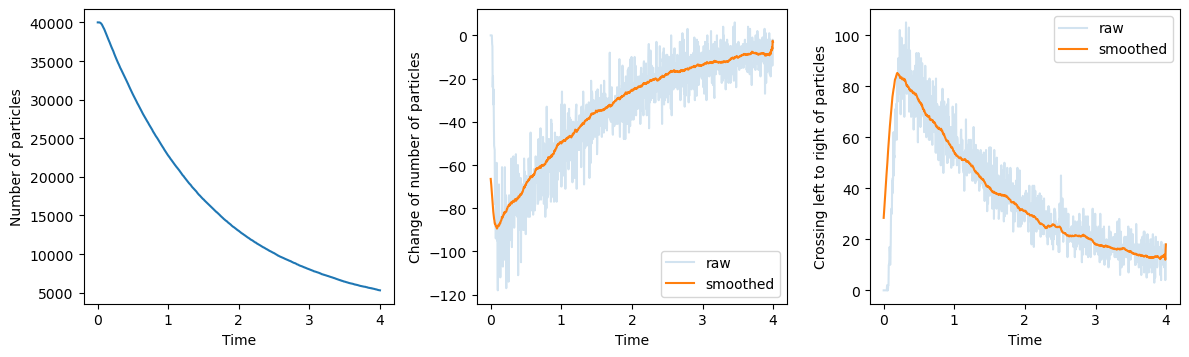

tensor(0.4488) tensor(0.0104)


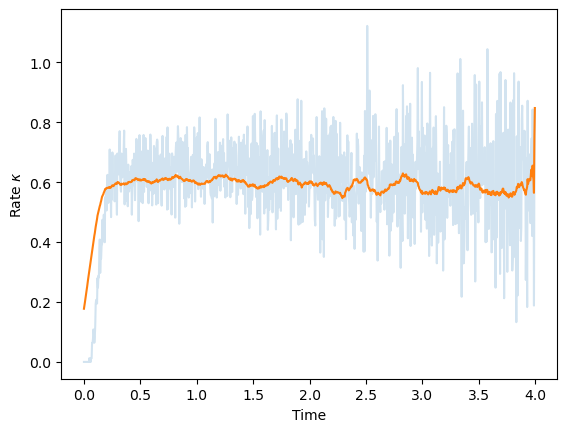

In [11]:
stat_F = 2e-3
pos, rate_const, crossing_rate_const ,time_const = plot_simulated_rate(
    tau=tau,
    k=k,
    num_particle=num_particle,
    border=border,
    F= lambda i:stat_F,
    max_t=max_t,
    dt=dt,
    safe_name='const_force')
    
#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Force Ramp

got 1000


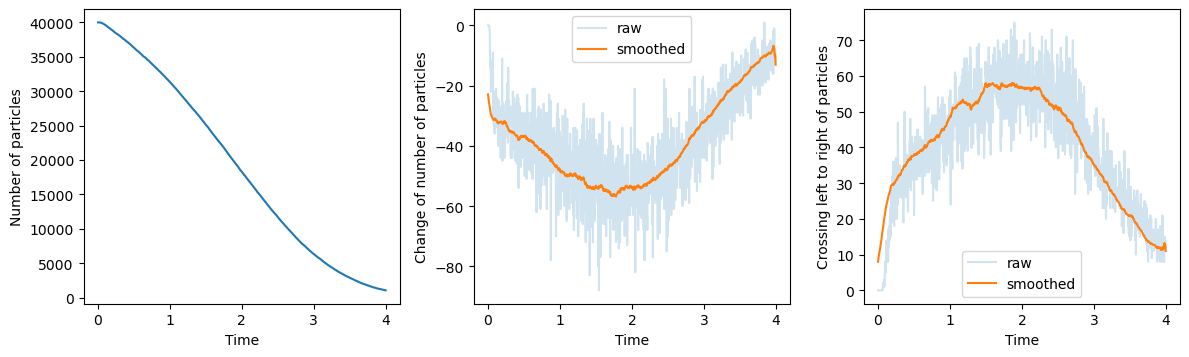

tensor(1.4329) tensor(0.0283)


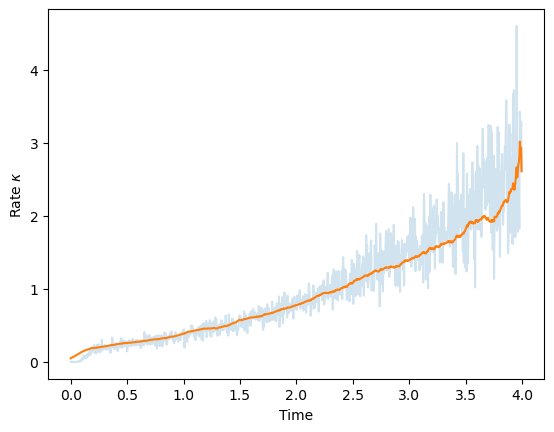

In [12]:
pos, rate_ramp,crossing_rate_ramp, time_ramp = plot_simulated_rate(
    k=k,
    tau=tau,
    num_particle=num_particle,
    border=border,
    F= lambda i: 0.005*i/(max_t),
    max_t = max_t,
    dt=dt,
    safe_name='force_ramp')

#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Oszillatory driving

got 1000


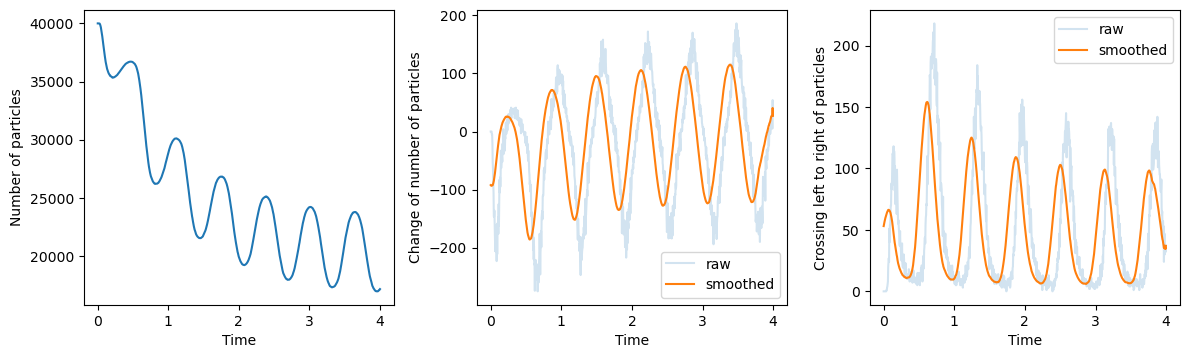

tensor(0.0782) tensor(0.0523)


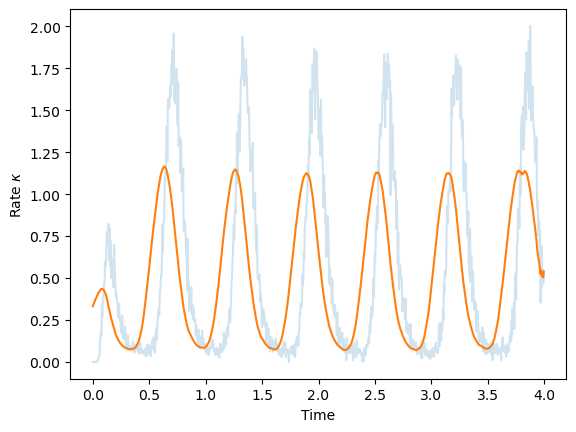

In [13]:
pos, rate_oszi,crossing_rate_oszi, time_oszi = plot_simulated_rate(
    k=k,
    tau = tau,
    num_particle=num_particle,
    border=border,
    F= lambda i: 0.005*np.cos(i * 10),
    max_t = max_t, 
    dt=dt,
    safe_name='oszi_force')

#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Bullerjan

In [14]:
my_fpc = FokkerPlankCalculator()
s = np.sqrt(2*D)
b= border

# prot = 'oszi'

forces = {
    "no": lambda i: 0,
    "const": lambda i:stat_F,
    "ramp": lambda i: 0.005*i/(max_t),
    "oszi": lambda i: 0.005*np.cos(i * 10)
}

# sim_res = {
#     "no": rate_no_force,
#     "const": rate_const,
#     "ramp": rate_ramp,
#     "oszi": rate_oszi
# }

sim_res = {
    "no": crossing_rate_no_force,
    "const": crossing_rate_const,
    "ramp": crossing_rate_ramp,
    "oszi": crossing_rate_oszi
}

forces_bound_min = forces
sime_res_bound_min = sim_res
# %store sime_res_bound_min
with open('nummeric_results/sime_res_bound_min.pkl','wb') as f:
    pickle.dump(sime_res_bound_min, f)

3499


/tmp/ipykernel_16769/4090434832.py:45: RuntimeWarning: divide by zero encountered in divide
  j = (w*b-G-2*D_t*(b-mu)/var) * 1 / np.sqrt(2*np.pi*var) * np.exp(-(b-mu)**2/(2*var)) #2 or 4
/tmp/ipykernel_16769/4090434832.py:45: RuntimeWarning: invalid value encountered in multiply
  j = (w*b-G-2*D_t*(b-mu)/var) * 1 / np.sqrt(2*np.pi*var) * np.exp(-(b-mu)**2/(2*var)) #2 or 4
/tmp/ipykernel_16769/4090434832.py:47: RuntimeWarning: divide by zero encountered in divide
  S = 1/2*(1+erf( (b-mu)/np.sqrt(2*var)))
/tmp/ipykernel_16769/4090434832.py:53: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axs[0,0].set_ylim(np.sort(G)[11], np.sort(G)[-11])


3499
3499
3499


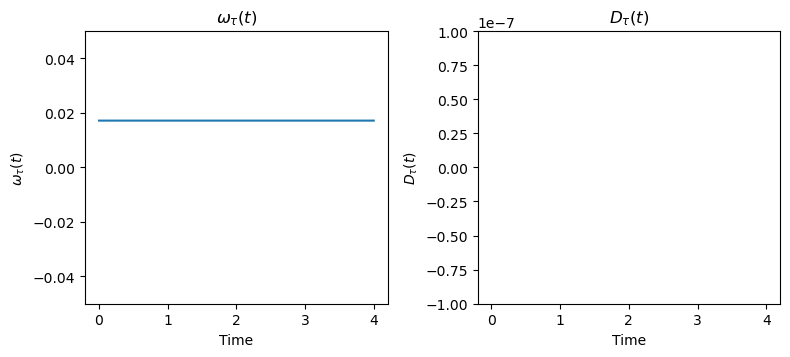

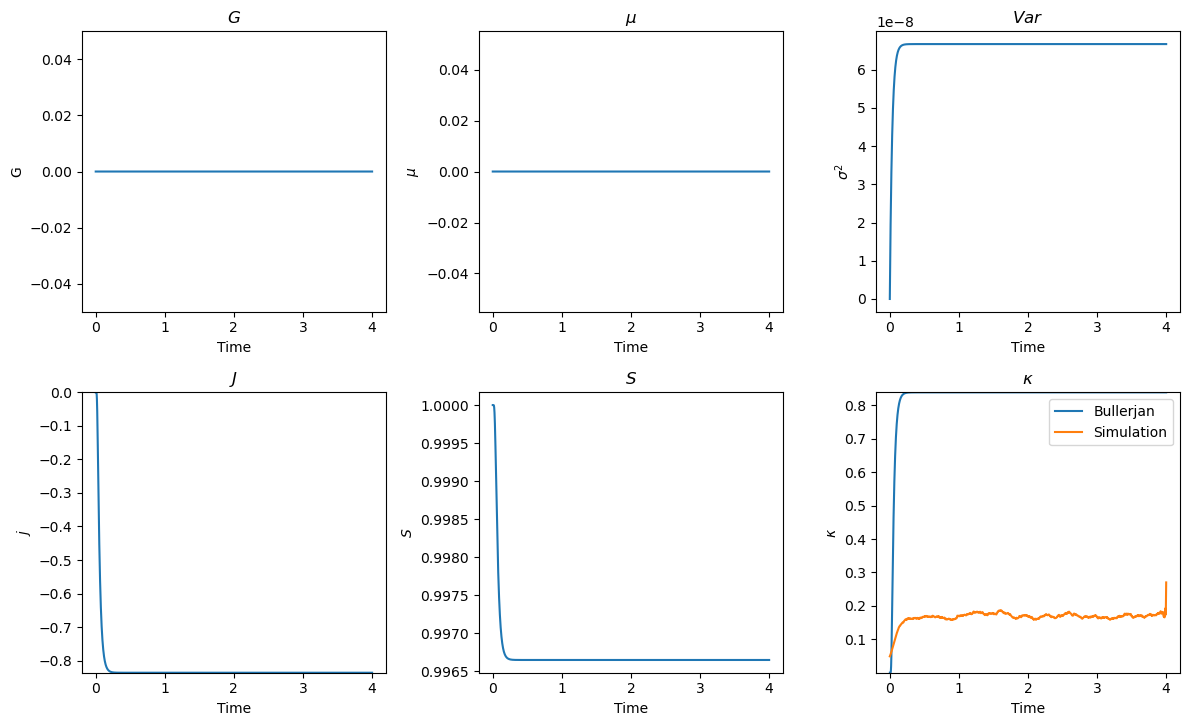

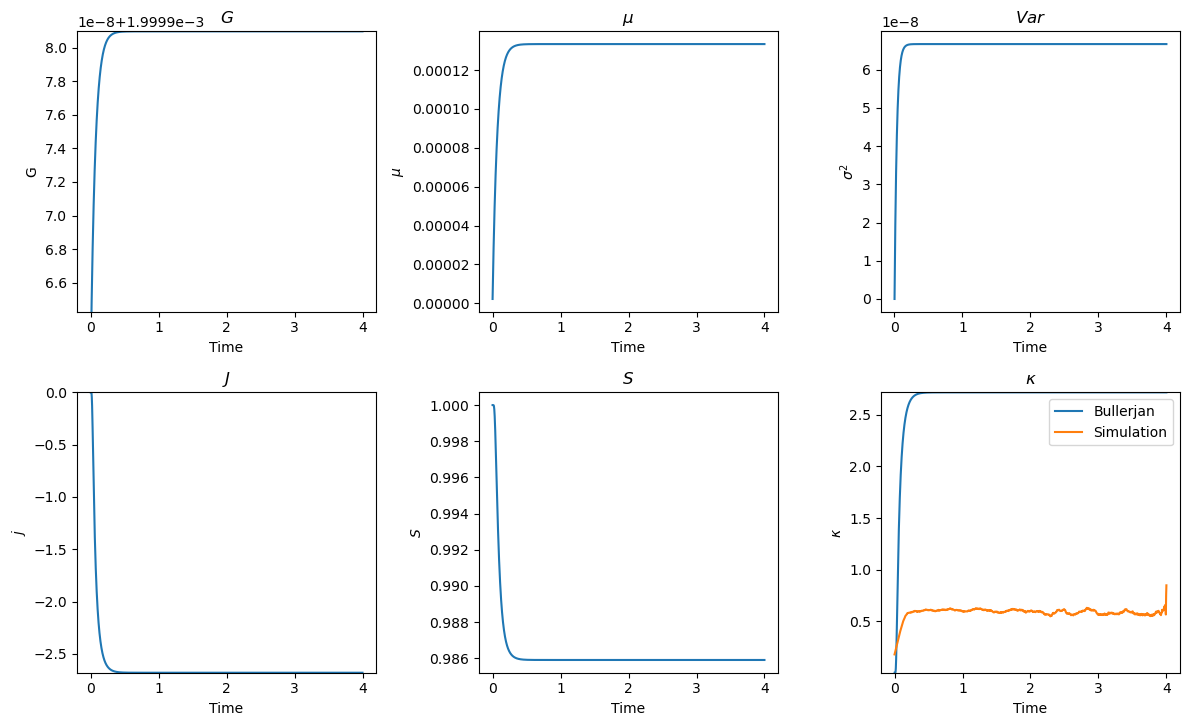

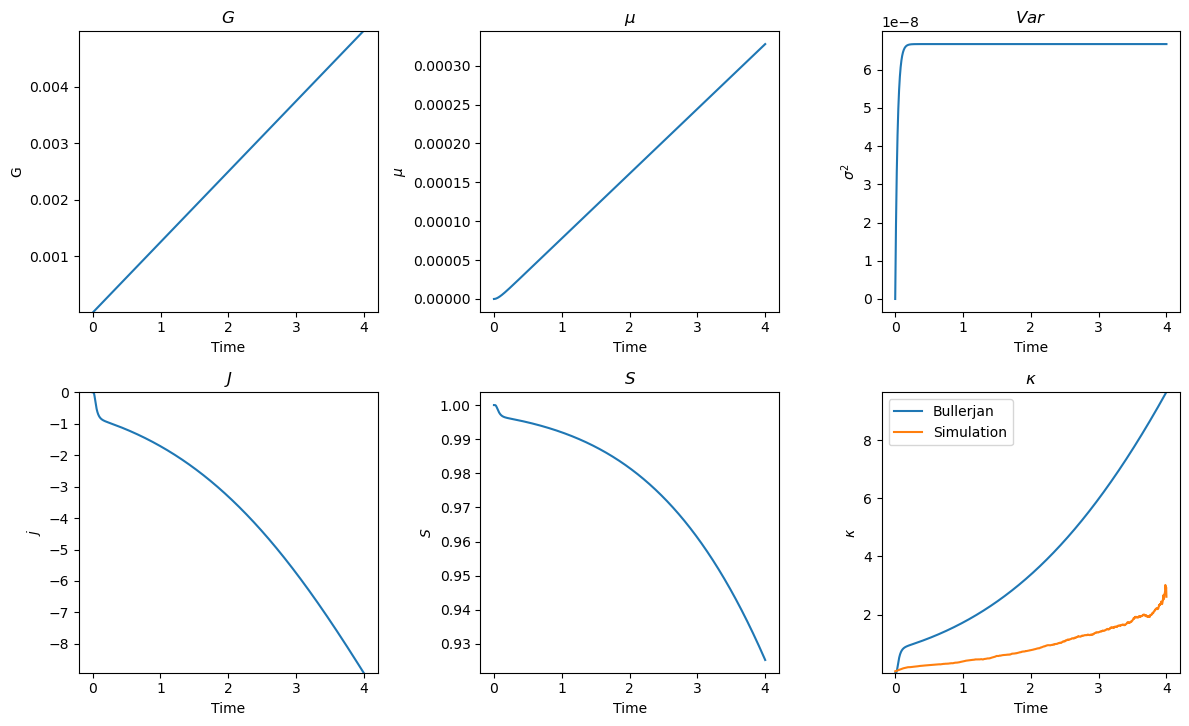

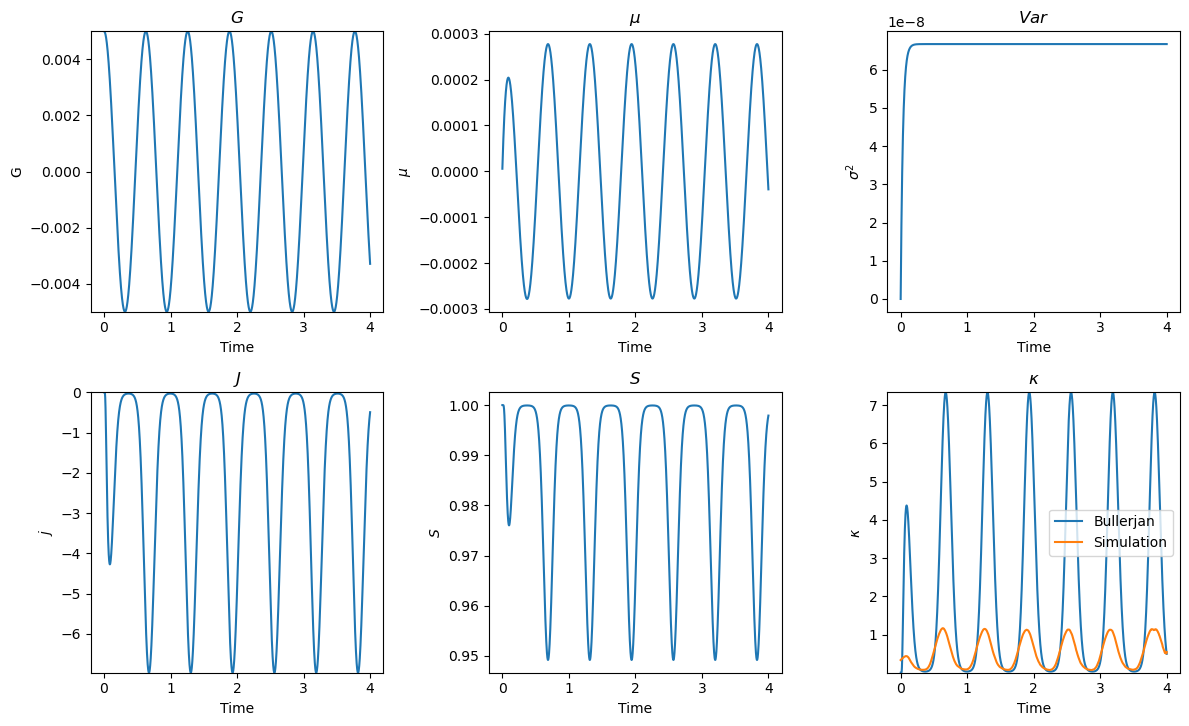

In [15]:
ts_all = np.linspace(0, max_t, 6999)
ts = ts_all[::2]
ts_ = ts_all[1::2]


if tau > 0:
    max_p = int(max_t / tau) + 1
    l_data_all = my_fpc.l(k, tau, ts_all, max_p=max_p)
else:
    l_data_all = np.exp(-k*ts_all)
l_data = l_data_all[::2]
l_data_ = l_data_all[1::2]

w = my_fpc.get_w(l_data, l_data_)
D_t = my_fpc.get_D(l_data, l_data_, ts, max_t,D)

fig, axs = plt.subplots(1,2, figsize=(8, 4))
axs[0].plot(ts_,w)
axs[0].set_ylim(-0.05,0.05)
axs[0].set_title(r"$\omega_\tau(t)$")
axs[0].set_xlabel("Time")
axs[0].set_ylabel(r"$\omega_\tau(t)$")


axs[1].plot(ts_,D_t)
axs[1].set_ylim(-1e-7,1e-7)
axs[1].set_title(r"$D_\tau(t)$")
axs[1].set_xlabel("Time")
axs[1].set_ylabel(r"$D_\tau(t)$")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

if save_run:
    plt.savefig(pic_path/f'omega_diff.pdf')

for prot in sim_res:
    my_F = np.vectorize(forces[prot])  #lambda i: 0 
    F_data = my_F(ts)
    F_data_ = my_F(ts_)
    G = my_fpc.get_G(l_data,l_data_,ts, F_data, max_t)

    mu = my_fpc.get_M(l_data_,F_data_, ts_, max_t)

    var = my_fpc.get_v_n(l_data_, ts_, max_t, s = s)

    j = (w*b-G-2*D_t*(b-mu)/var) * 1 / np.sqrt(2*np.pi*var) * np.exp(-(b-mu)**2/(2*var)) #2 or 4

    S = 1/2*(1+erf( (b-mu)/np.sqrt(2*var)))


    fig, axs = plt.subplots(2,3, figsize=(12, 8))
    axs[0,0].plot(ts_,G)
    axs[0,0].set_title(r"$G$")
    axs[0,0].set_ylim(np.sort(G)[11], np.sort(G)[-11])
    axs[0,0].set_xlabel("Time")
    axs[0,0].set_ylabel("G")

    axs[0,1].plot(ts_,mu)
    axs[0,1].set_title(r"$\mu$")
    axs[0,1].set_xlabel("Time")
    axs[0,1].set_ylabel("$\mu$")

    axs[0,2].plot(ts_,var)
    axs[0,2].set_title(r"$Var$")
    axs[0,2].set_xlabel(r"Time")
    axs[0,2].set_ylabel(r"$\sigma^2$")

    #axs[1,2].plot(ts_,(1-S))
    #axs[1,2].set_title(r"$(1-S)$")
    #axs[1,2].plot(time_ramp, sim_res[prot])

    axs[1,0].plot(ts_,j)
    axs[1,0].set_ylim(np.sort(j)[4], np.sort(j)[-4])
    axs[1,0].set_title(r"$J$")
    axs[1,0].set_xlabel(r"Time")
    axs[1,0].set_ylabel(r"$j$")

    axs[1,1].plot(ts_,S)
    axs[1,1].set_title(r"$S$")
    axs[1,1].set_xlabel(r"Time")
    axs[1,1].set_ylabel(r"$S$")

    axs[1,2].plot(ts_, -j/S, label='Bullerjan')
    axs[1,2].plot(time_ramp, sim_res[prot], label='Simulation') 
    axs[1,2].set_ylim(np.sort(-j/S)[4], np.sort(-j/S)[-4])
    axs[1,2].set_title(r"$\kappa$")
    axs[1,2].legend()
    axs[1,2].set_xlabel(r"Time")
    axs[1,2].set_ylabel(r"$\kappa$")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_run:
        plt.savefig(pic_path/f'escape_rate_{prot}.pdf')